# VaR & CVaR based on Energy Factors - Montecarlo approach

In [163]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import time
import cvxpy as cp
from scipy.optimize import minimize
import yfinance as yf
import warnings 
from tqdm import tqdm
warnings.filterwarnings('ignore')

## Parametri

In [164]:
##storico totale
start_date  = '2010-01-01'
end_date    = '2023-06-30'
timeframe   = 'M'
rolling_p   = 6
std_mode    = 'mean' #mean, median , max , q75, q90

stock_symb  = 'XOM'
fact_symbs  = 'NG=F, CL=F, MTF=F, HO=F, ICLN, IXC, URA'
cv_folds    = 5

num_years   = 10
num_runs    = 5000

## Download

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA,XOM
Date,,,,,,,,
2010-12-20,0.008935,0.006367,-0.001978,0.008960,0.000000,0.041196,0.012177,0.000693
2010-12-21,0.011308,0.010747,0.012691,0.005527,0.006104,-0.042919,0.003524,0.006900
2010-12-22,0.007321,0.004797,0.000000,0.005497,0.018091,0.022653,-0.001005,0.001099
2010-12-23,0.011319,0.004853,-0.003790,0.003648,-0.001994,-0.016758,0.000000,0.005479
2010-12-27,-0.005589,-0.009570,-0.002535,-0.001562,-0.001998,0.007077,-0.003023,-0.002599
...,...,...,...,...,...,...,...,...
2023-06-23,-0.005048,-0.023972,-0.016732,-0.012205,-0.005636,0.045352,-0.025482,-0.008751
2023-06-26,0.003032,0.013083,0.002247,0.016881,-0.003048,0.022465,0.000938,0.018289
2023-06-27,-0.024368,-0.016454,0.008939,-0.001923,0.000000,-0.010083,-0.005642,0.002490


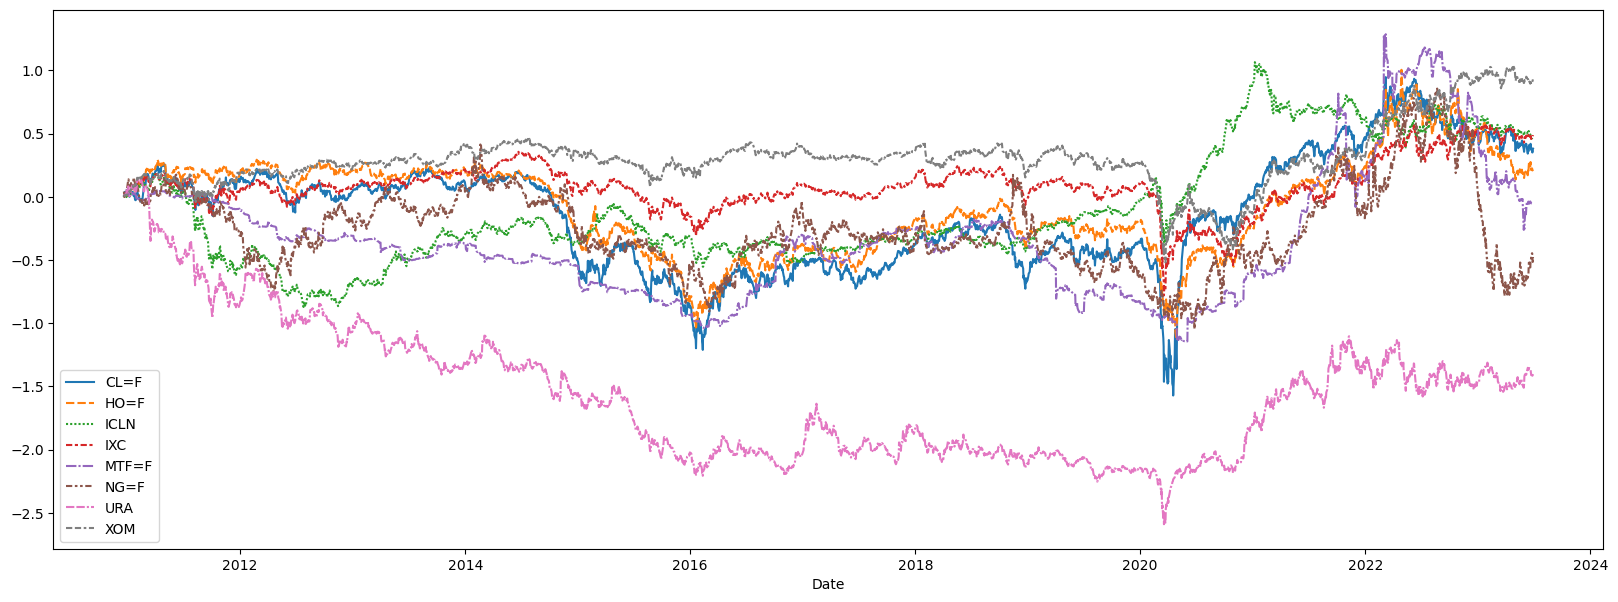

In [165]:
energy_factors = yf.download(fact_symbs,start=start_date, end=end_date)['Adj Close']
energy_factors = np.log1p(energy_factors.pct_change())

stock = yf.download(stock_symb,start=start_date, end=end_date)['Adj Close']
stock_last_prince = float(stock[-1])
stock = np.log1p(stock.pct_change())
stock.name = stock_symb

daily_data = pd.concat([energy_factors, stock], axis=1).dropna()
plt.figure(figsize=(20,7))
sns.lineplot(daily_data.cumsum())
daily_data

## Utility Functions

In [166]:
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['time_period'] = 'all'
    options['date'] = 'Date'
    options['return_model'] = False
    options['print_loadings'] = True
    return options

def create_options_lasso():
    options = create_options()
    options['lambda_hat'] = .5
    return options

def create_options_cv_lasso():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['n_lambda_hat'] = 250
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_ridge():
    options = create_options()
    options['max_lambda'] = 1
    options['n_lambda'] = 250
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_elastic_net():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['max_l1_ratio'] = .99
    options['n_lambda_hat'] = 250
    options['n_l1_ratio'] = 20
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_best_subset():
    '''create standard options dictionary to be used as input to regression functions'''
    options = create_options()
    options['return_model'] = False
    options['print_loadings'] = True
    options['max_vars'] = 3
    return options

def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'

def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('name_of_reg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['name_of_reg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['time_period'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

def linear_regression(data, dependentVar, factorNames, options):
    '''linear_regression takes in a dataset and returns the factor loadings using least squares regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    linReg = LinearRegression(fit_intercept=True)
    linReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        # Now print the factor loadings
        display_factor_loadings(linReg.intercept_, linReg.coef_, factorNames, options)

    if(options['return_model']):
        return linReg
      
def lasso_regression(data, dependentVar, factorNames, options):
    '''lasso_regression takes in a dataset and returns the factor loadings using lasso regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            printLoadings: boolean, if true, prints the coeficients

            date: name of datecol
            returnModel: boolean, if true, returns model
            alpha: float, alpha value for LASSO regression
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda_hat' not in options.keys()):
        print ('lambda_hat not specified in options')
        return

    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    lassoReg = Lasso(alpha=options['lambda_hat'], fit_intercept=True)
    lassoReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda_hat = ' + str(options['lambda_hat']))

        #Now print the factor loadings
        display_factor_loadings(lassoReg.intercept_, lassoReg.coef_, factorNames, options)
        
def cross_validated_lasso_regression(data, dependentVar, factorNames, options):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphas = np.logspace(-12, np.log(options['max_lambda_hat']), base=np.exp(1), num=options['n_lambda_hat'])
    #alphas = np.linspace(1e-12, alphaMax, options['nAlphas'])
    if(options['random_state'] == 'none'):
        lassoTest = Lasso(fit_intercept=True)
    else:
        lassoTest = Lasso(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(lassoTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    lassoBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(lassoBest.intercept_, lassoBest.coef_, factorNames, options)

    if(options['return_model']):
        return lassoBest
    
def cross_validated_ridge_regression(data, dependentVar, factorNames, options):
    '''cross_validated_ridge_regression takes in a dataset and returns the factor loadings using ridge regression and choosing lambda via ridge regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda'], base=np.exp(1))
    if(options['randomState'] == 'none'):
        ridgeTest = Ridge(fit_intercept=True)
    else:
        ridgeTest = Ridge(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(ridgeTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    ridgeBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best Lambda = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(ridgeBest.intercept_, ridgeBest.coef_, factorNames, options)

    if(options['return_model']):
        return ridgeBest

def cross_validated_elastic_net_regression(data, dependentVar, factorNames, options):
    '''cross_validated_elastic_net_regression takes in a dataset and returns the factor loadings using elastic net, also chooses alpha and l1 ratio via cross validation
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            maxL1Ratio: float
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda_hat']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda_hat'])
    l1RatioMax = options['max_l1_ratio']
    l1Ratios = np.linspace(1e-6, l1RatioMax, options['n_l1_ratio'])
    if(options['random_state'] == 'none'):
        elasticNetTest = ElasticNet(fit_intercept=True)
    else:
        elasticNetTest = ElasticNet(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas, 'l1_ratio': l1Ratios}]

    clf = GridSearchCV(elasticNetTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    elasticNetBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']
    l1RatioBest = clf.best_params_['l1_ratio']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        print('Best l1 ratio = ' + str(l1RatioBest))
        #Now print the factor loadings
        display_factor_loadings(elasticNetBest.intercept_, elasticNetBest.coef_, factorNames, options)

    if(options['return_model']):
        return elasticNetBest

def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 1000
    n_factor = x.shape[1]
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset_prob = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset_prob.solve(solver='ECOS_BB')
    return alpha.value, beta.value

def best_subset_regression(data, dependentVar, factorNames, options):
    '''best_subset_regression takes in a dataset and returns the factor loadings using best subset regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            maxVars: int, maximum number of factors that can have a non zero loading in the resulting regression
            printLoadings: boolean, if true, prints the coeficients
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Check dictionary for maxVars option
    if('max_vars' not in options.keys()):
        print ('max_vars not specified in options')
        return

    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    alpha, beta = best_subset(data[factorNames].values, data[dependentVar].values, options['max_vars'])
    #round beta values to zero
    beta[np.abs(beta) <= 1e-7] = 0.0
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Max Number of Non-Zero Variables is ' + str(options['max_vars']))

        #Now print the factor loadings
        display_factor_loadings(alpha, beta, factorNames, options)

    if(options['return_model']):
        out = LinearRegression()
        out.intercept_ = alpha[0]
        out.coef_ = beta
        return out


In [167]:
def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def var_cornishfisher(r, level=5):
    """
    Returns the Parametric Gausian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
   
    # modify the Z score based on observed skewness and kurtosis
    s = skewness(r)
    k = kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return -(r.mean() + z*r.std(ddof=0))

## DATA

In [168]:
resampled_data = daily_data.copy()
resampled_data.dropna(how='any', inplace=True)

if timeframe == 'W':
    resampled_data = resampled_data.resample('W').sum()
elif timeframe == 'M':
    resampled_data = resampled_data.resample('M').sum()
elif timeframe == 'Q':
    resampled_data = resampled_data.resample('Q').sum()

resampled_data.dropna(how='any', inplace=True)
factors = resampled_data.drop(stock_symb, axis=1).columns.tolist()
resampled_data.reset_index(inplace=True)
resampled_data.rename(columns={'index': 'Date'}, inplace=True)

# Continue with the rest of your code using the resampled_data
resampled_data

,Date,CL=F,HO=F,ICLN,IXC,MTF=F,NG=F,URA,XOM
0,2010-12-31,0.037463,0.027905,0.011818,0.039372,0.074691,0.080081,0.063494,0.013078
1,2011-01-31,0.008825,0.076817,0.040216,0.058423,-0.101580,0.003399,0.019352,0.098389
2,2011-02-28,0.050550,0.063131,0.040992,0.061349,0.006270,-0.090638,0.000958,0.063632
3,2011-03-31,0.095807,0.054538,0.092767,0.008818,0.060625,0.083600,-0.341271,-0.016504
4,2011-04-30,0.065376,0.052332,-0.025794,0.022042,0.002741,0.068035,-0.037740,0.044746
...,...,...,...,...,...,...,...,...,...
146,2023-02-28,-0.023346,-0.120548,-0.077154,-0.050744,0.066916,0.023201,-0.095614,-0.046349
147,2023-03-31,-0.018073,-0.052621,0.029761,-0.012370,-0.054181,-0.214806,-0.048957,-0.002277
148,2023-04-30,0.014562,-0.117881,-0.055613,0.040483,0.014643,0.083923,0.003506,0.076177
149,2023-05-31,-0.120114,-0.051366,-0.019974,-0.102201,-0.389139,-0.061611,-0.005515,-0.138186


In [169]:
factors

['CL=F', 'HO=F', 'ICLN', 'IXC', 'MTF=F', 'NG=F', 'URA']

## OLS Regression

In [170]:
options = create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = True
ols_model_train = linear_regression(resampled_data, stock_symb, factors, options)

Dependent Variable is XOM
Time period is between December 2010 to June 2023 inclusive   
               Intercept      CL=F      HO=F      ICLN       IXC     MTF=F  \
OLS full data    0.00303  0.014741 -0.056346 -0.155737  1.033238 -0.015529   

                   NG=F       URA  
OLS full data  0.019244 -0.042467  


## Penalized Regressions (Lasso , Elastic Net)

In [171]:
options = create_options_cv_lasso()
options['name_of_reg'] = 'CV Lasso'
options['max_lambda_hat'] = .01 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
options['return_model'] = True
options['n_folds'] = cv_folds 
lasso_model_train = cross_validated_lasso_regression(resampled_data, stock_symb, factors, options)

Dependent Variable is XOM
Time period is between December 2010 to June 2023 inclusive   
Best lambda_hat = 9.881658333646441e-06
          Intercept      CL=F      HO=F      ICLN      IXC    MTF=F      NG=F  \
CV Lasso   0.003048  0.012982 -0.052591 -0.152727  1.02803 -0.01494  0.018661   

               URA  
CV Lasso -0.041018  


In [172]:
# options = create_options_cv_elastic_net()
# options['name_of_reg'] = 'CV Elastic Net'
# options['max_lambda_hat'] = .01
# options['return_model'] = True
# options['n_folds'] = cv_folds
# en_model_train = cross_validated_elastic_net_regression(resampled_data, stock_symb, factors, options)

In [173]:
# en_model_train.score

In [174]:
intercept = lasso_model_train.intercept_
betas = lasso_model_train.coef_
betas = betas.tolist()

In [175]:
pd.DataFrame(betas , index=factors).sort_index()

,0
CL=F,0.012982
HO=F,-0.052591
ICLN,-0.152727
IXC,1.028030
MTF=F,-0.014940
NG=F,0.018661
URA,-0.041018


## VIF Collinearity

In [176]:
# the independent variables set
X = resampled_data[factors]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data.sort_values('VIF', ascending=False))


  feature       VIF
0    CL=F  3.134118
3     IXC  2.839833
1    HO=F  2.315494
6     URA  1.569729
2    ICLN  1.500213
5    NG=F  1.248318
4   MTF=F  1.235420


## Dataset for Montecarlo

In [177]:
# Retrieve the historical data
df_factors = resampled_data.drop(['Date',stock_symb], axis=1).dropna()

# Compute mean returns for each factor
mean_returns = df_factors.mean()

# Compute the rolling volatility
rolling_volatility = df_factors.rolling(window=rolling_p).std()

# Compute the maximum rolling volatility over the last 15 years for each factor
if std_mode == 'median':
    _rolling_volatility = rolling_volatility.median()
elif std_mode == 'mean':
    _rolling_volatility = rolling_volatility.mean()
elif std_mode == 'max':
    _rolling_volatility = rolling_volatility.max()
elif std_mode == 'q75':
    _rolling_volatility = rolling_volatility.quantile(0.75) 
elif std_mode == 'q90':
    _rolling_volatility = rolling_volatility.quantile(0.90) 

# Store the maximum rolling volatility for each factor in sigmas_list
sigmas_list = _rolling_volatility.tolist()

mean_returns_list = mean_returns.tolist()

print("Mean Returns:", mean_returns_list)
print("Rolling Volatility:", sigmas_list)

Mean Returns: [0.0025263329540234684, 0.0014242948414115956, 0.0031154827993837356, 0.0032305400779287555, -0.00036557309264346815, -0.003171837842017415, -0.009289022599614288]
Rolling Volatility: [0.10159982387111846, 0.08887989736312205, 0.07108909481323726, 0.06506421764096557, 0.08593024579827059, 0.12474121127546721, 0.09892373205616103]


## Montecarlo simulation

Generating future stock prices: 100%|██████████| 119/119 [00:02<00:00, 54.63it/s]


XOM: next 10 years | 5000 iterations
Energy Factors: ['CL=F', 'HO=F', 'ICLN', 'IXC', 'MTF=F', 'NG=F', 'URA']


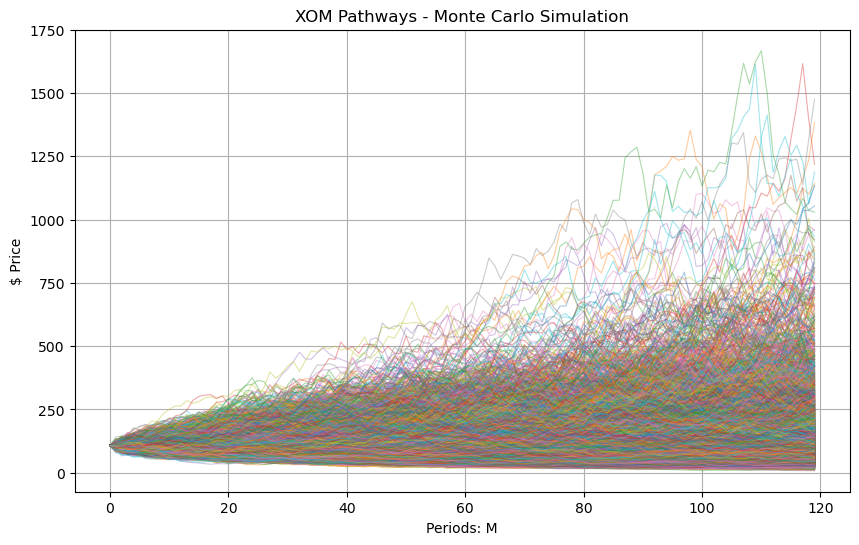

In [178]:
if timeframe=='D':
    n_steps = num_years * 252
elif timeframe=='W':
    n_steps = num_years * 52
elif timeframe=='M':
    n_steps = num_years * 12
elif timeframe=='Q':
    n_steps = num_years * 4


initial_stock_price = float(stock_last_prince)  

#Brownian motion
brownian_motion_paths = []
for i in range(len(mean_returns_list)):
    brownian_motion_path = np.random.normal(mean_returns_list[i], sigmas_list[i], size=(num_runs, n_steps))
    brownian_motion_paths.append(brownian_motion_path)

# Generate future stock prices
future_stock_prices = np.zeros((num_runs, n_steps))
future_stock_prices[:, 0] = initial_stock_price  

for i in tqdm(range(1, n_steps), desc='Generating future stock prices'):
    for j in range(num_runs):
        energy_factor_returns = np.dot([brownian_motion_paths[k][j, i-1] for k in range(len(mean_returns_list))], betas)
        future_stock_price = future_stock_prices[j, i-1] * (1 + energy_factor_returns)
        future_stock_prices[j, i] = max(future_stock_price, 0.0)


# Compute stock returns
stock_returns = np.diff(future_stock_prices, axis=1) / future_stock_prices[:, :-1]
stock_returns = stock_returns[~np.isnan(stock_returns).any(axis=1)]

print(f'{stock_symb}: next {num_years} years | {num_runs} iterations')
print(f'Energy Factors: {factors}')

# Plot stock pathways
plt.figure(figsize=(10, 6))
for i in range(num_runs):
    plt.plot(range(n_steps), future_stock_prices[i], linewidth=0.8, alpha=0.4)

plt.xlabel(f'Periods: {timeframe}')
plt.ylabel('$ Price')
plt.title(f'{stock_symb} Pathways - Monte Carlo Simulation')
plt.grid(True)
plt.show()

## VaR and CVaR Plots

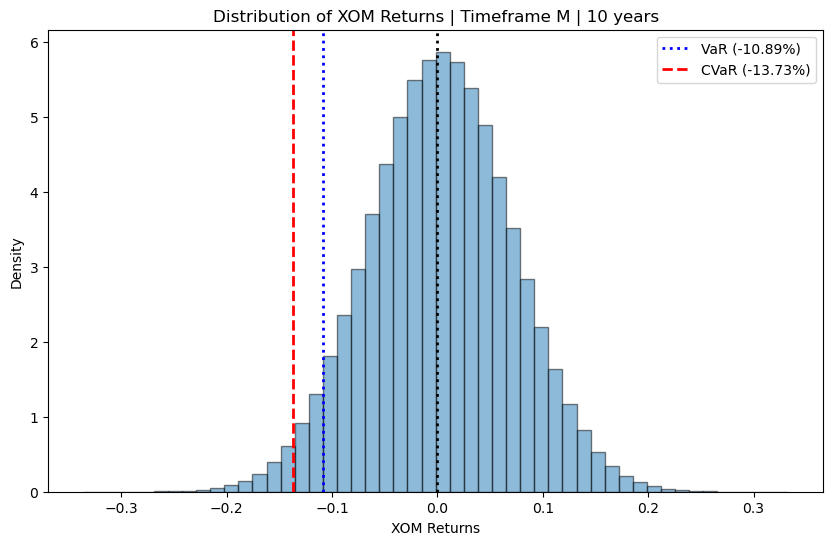

In [179]:
# Plot the distribution of returns
plt.figure(figsize=(10, 6))
plt.hist(stock_returns.flatten(), bins=50, density=True, edgecolor='k', alpha=0.5)
plt.xlabel(f'{stock_symb} Returns')
plt.ylabel('Density')
plt.title(f'Distribution of {stock_symb} Returns | Timeframe {timeframe} | {num_years} years')

# Compute Cornish-Fisher VaR
VaR = -var_cornishfisher(stock_returns, level=5)  # Convert to percentages
CVaR = stock_returns[stock_returns <= VaR].mean()


# Format VaR and CVaR as percentages with two decimal points
var_formatted = "{:.2f}%".format(VaR * 100)
cvar_formatted = "{:.2f}%".format(CVaR * 100)

# Plot vertical lines for VaR and CVaR with formatted values in the legend
plt.axvline(VaR, color='blue', linestyle='dotted', linewidth=2, label=f'VaR ({var_formatted})')
plt.axvline(CVaR, color='red', linestyle='--', linewidth=2, label=f'CVaR ({cvar_formatted})')
plt.axvline(0.0, color='black', linestyle='dotted', linewidth=2)

# Add legend
plt.legend()

# Show the plot
plt.show()

